# Task 3 model

This notebook demonstrates some progress on developing the task three model. It is structured as a python 3 package, to allow the model to be run in a straightforward and intuitive way. We start by loading some packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils.microtype import Microtype
from utils.network import Network, NetworkCollection, NetworkFlowParams, Mode, BusMode, BusModeParams

We can then create some road networks. We're creating several stacked networks, because not all modes have access to all ROW

In [2]:
network_params_car = NetworkFlowParams(0.068, 15.42, 1.88, 0.145, 0.177, 50)

network_car = Network(1000, network_params_car)

Given that set of networks, we can define the set of modes that operate on these networks. In defining the bus mode, we tell it the number of buses operating in the microtype, which is assumed to be fixed.

In [3]:
car = Mode([network_car], 'car')

This network is enough to define a microtype

In [4]:
m = Microtype(NetworkCollection([network_car]))

From there, we can add demand for different modes

In [5]:
m.setModeDemand('car', 6 / 60, 1000.0)

[11.766850941092859]
[11.333415739624723]
[11.244856812061876]
[11.225372760361322]
[11.221019315602955]
[11.220043272470607]


Once you add demand, the microtype iterates until it has reached a steady state equilibrium. In doing so, it prints the car speed on each of the subnetworks. Note that the car speed on the mixed and car only subnetworks are equal, which is a condition for user equilibrium.

Increasing the demand leads to slower average speeds

In [6]:
m.setModeDemand('car', 8 / 60, 1000.0)

[10.247235820129223]
[9.832265319379172]
[9.626187079799555]
[9.516667625116222]
[9.456434673615284]
[9.42269406809721]
[9.40360095416427]
[9.392734848814039]
[9.386530840355531]
[9.382982143338259]
[9.38095015457461]
[9.379785936110176]
[9.379118673150316]


We can see how this changes for different levels of demand

Text(0.5, 0, 'Total demand')

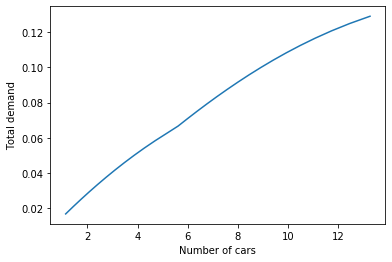

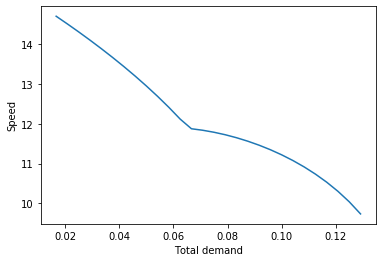

In [7]:
m.networks.verbose = False
demands = np.arange(1/60,8/60,0.25/60)
speeds = []
flows = []
Ns = []
for i in demands:
    m.setModeDemand('car', i, 1000.0)
    flows.append(m.getModeFlow('car'))
    speeds.append(m.networks.modes['car'].getSpeed())
    Ns.append(list(m.networks.modes['car']._N.values())[0])

plt.figure()
plt.plot(Ns,demands)
plt.xlabel('Number of cars')
plt.ylabel('Total demand')
plt.figure()
plt.plot(demands,speeds)
plt.ylabel('Speed')
plt.xlabel('Total demand')

We can also create stacks of sub-networks within a microtype. Here, we have one sub-network just for cars and one for cars and buses in mixed traffic

In [8]:
network_params_mixed = NetworkFlowParams(0.068, 15.42, 1.88, 0.145, 0.177, 50)
network_params_car = NetworkFlowParams(0.068, 15.42, 1.88, 0.145, 0.177, 50)

network_car = Network(750, network_params_car)
network_mixed = Network(250, network_params_mixed)

car = Mode([network_mixed, network_car], 'car')
bus = BusMode([network_mixed], BusModeParams(1.0))
nc2 = NetworkCollection([network_mixed, network_car])

m2 = Microtype(nc2)

We can add bus and car demand to the microtype

In [9]:
m2.setModeDemand('car', 0.1, 1000.0)
m2.setModeDemand('bus', 0.03, 1000.0)
m2.getSpeeds()

[10.205105804011254, 11.293535516899198]
[10.205105804011254, 10.275087354920153]
[9.936286850294481, 9.936286850294481]
[9.812652940302918, 9.812652940302922]
[9.765187272361837, 9.765187272361837]
[9.746616018339697, 9.746616018339697]
[9.739296480545834, 9.739296480545834]
[9.736403307546022, 9.736403307546022]
[9.735258433413614, 9.735258433413614]
[9.734805185430108, 9.73480518543011]
[9.734625715738133, 9.734625715738133]
[9.734554647282248, 9.734554647282252]
[9.734526504001124, 9.734526504001124]
[9.734515359070619, 9.734515359070617]


[5.274005161526256, 9.734515359070617]

With this, we can explore the costs for different combinations of bus and car demand. This shows that the higher the overall demand, the more bus mode is in the optimal solution, at least until the buses get too full

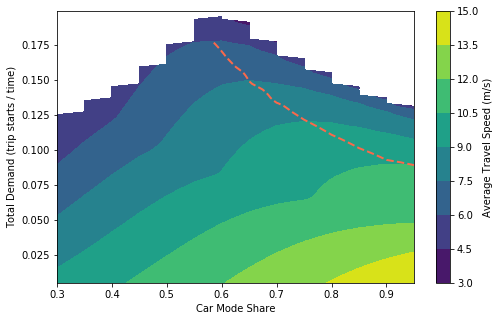

In [10]:
total_demands = np.arange(0.005, 0.2, 0.002)
mode_splits = np.arange(0.3, 1.0, 0.05)

average_costs = np.zeros((np.size(total_demands), np.size(mode_splits)))
flows = np.zeros((np.size(total_demands), np.size(mode_splits)))
car_speeds = np.zeros((np.size(total_demands), np.size(mode_splits)))
headways = np.zeros((np.size(total_demands), np.size(mode_splits)))
occupancies = np.zeros((np.size(total_demands), np.size(mode_splits)))

for ii in range(np.size(total_demands)):
    for jj in range(np.size(mode_splits)):
        car_demand = total_demands[ii] * mode_splits[jj]
        bus_demand = total_demands[ii] * (1.0 - mode_splits[jj])
        network_car = Network(750, network_params_car)
        network_mixed = Network(200, network_params_mixed)
        car = Mode([network_mixed, network_car], 'car')
        bus = BusMode([network_mixed], BusModeParams(1.0))
        nc = NetworkCollection([network_mixed, network_car], False)
        m = Microtype(nc)
        m.setModeDemand('car', car_demand, 1000.0)
        m.setModeDemand('bus', bus_demand, 1000.0)
        flows[ii, jj] = np.sum(m.getFlows())
        car_speeds[ii, jj] = m.getModeSpeed('car')
        average_costs[ii, jj] = np.sum(m.getTotalTimes()) / np.sum(m.getFlows())
        headways[ii, jj] = bus.getHeadway()
        occupancies[ii, jj] = bus.getOccupancy()

fig1 = plt.figure(figsize=(8, 5))

p1 = plt.contourf(mode_splits, total_demands, average_costs)  # , np.arange(0.08, 0.35, 0.02))
cb1 = plt.colorbar(p1)

cb1.set_label('Average Travel Speed (m/s)')

plt.ylabel('Total Demand (trip starts / time)')
plt.xlabel('Car Mode Share')

g1 = np.gradient(average_costs)

slope = g1[1] / g1[0]

p3 = plt.contour(mode_splits, total_demands, slope, 0, linestyles='dashed', linewidths=2,
                 cmap='Reds')
